In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#individual layers from keras
from tensorflow.keras.layers import Conv1D, LeakyReLU, GaussianNoise
from tensorflow.keras import ops

print(tf.config.list_physical_devices('GPU'))


2024-11-13 09:35:55.443445: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 09:35:55.666624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731508555.749483     987 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731508555.780374     987 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 09:35:56.021233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<b> Network architecture from Tarabanis et al. https://doi.org/10.1016/j.jacep.2022.09.021</b>


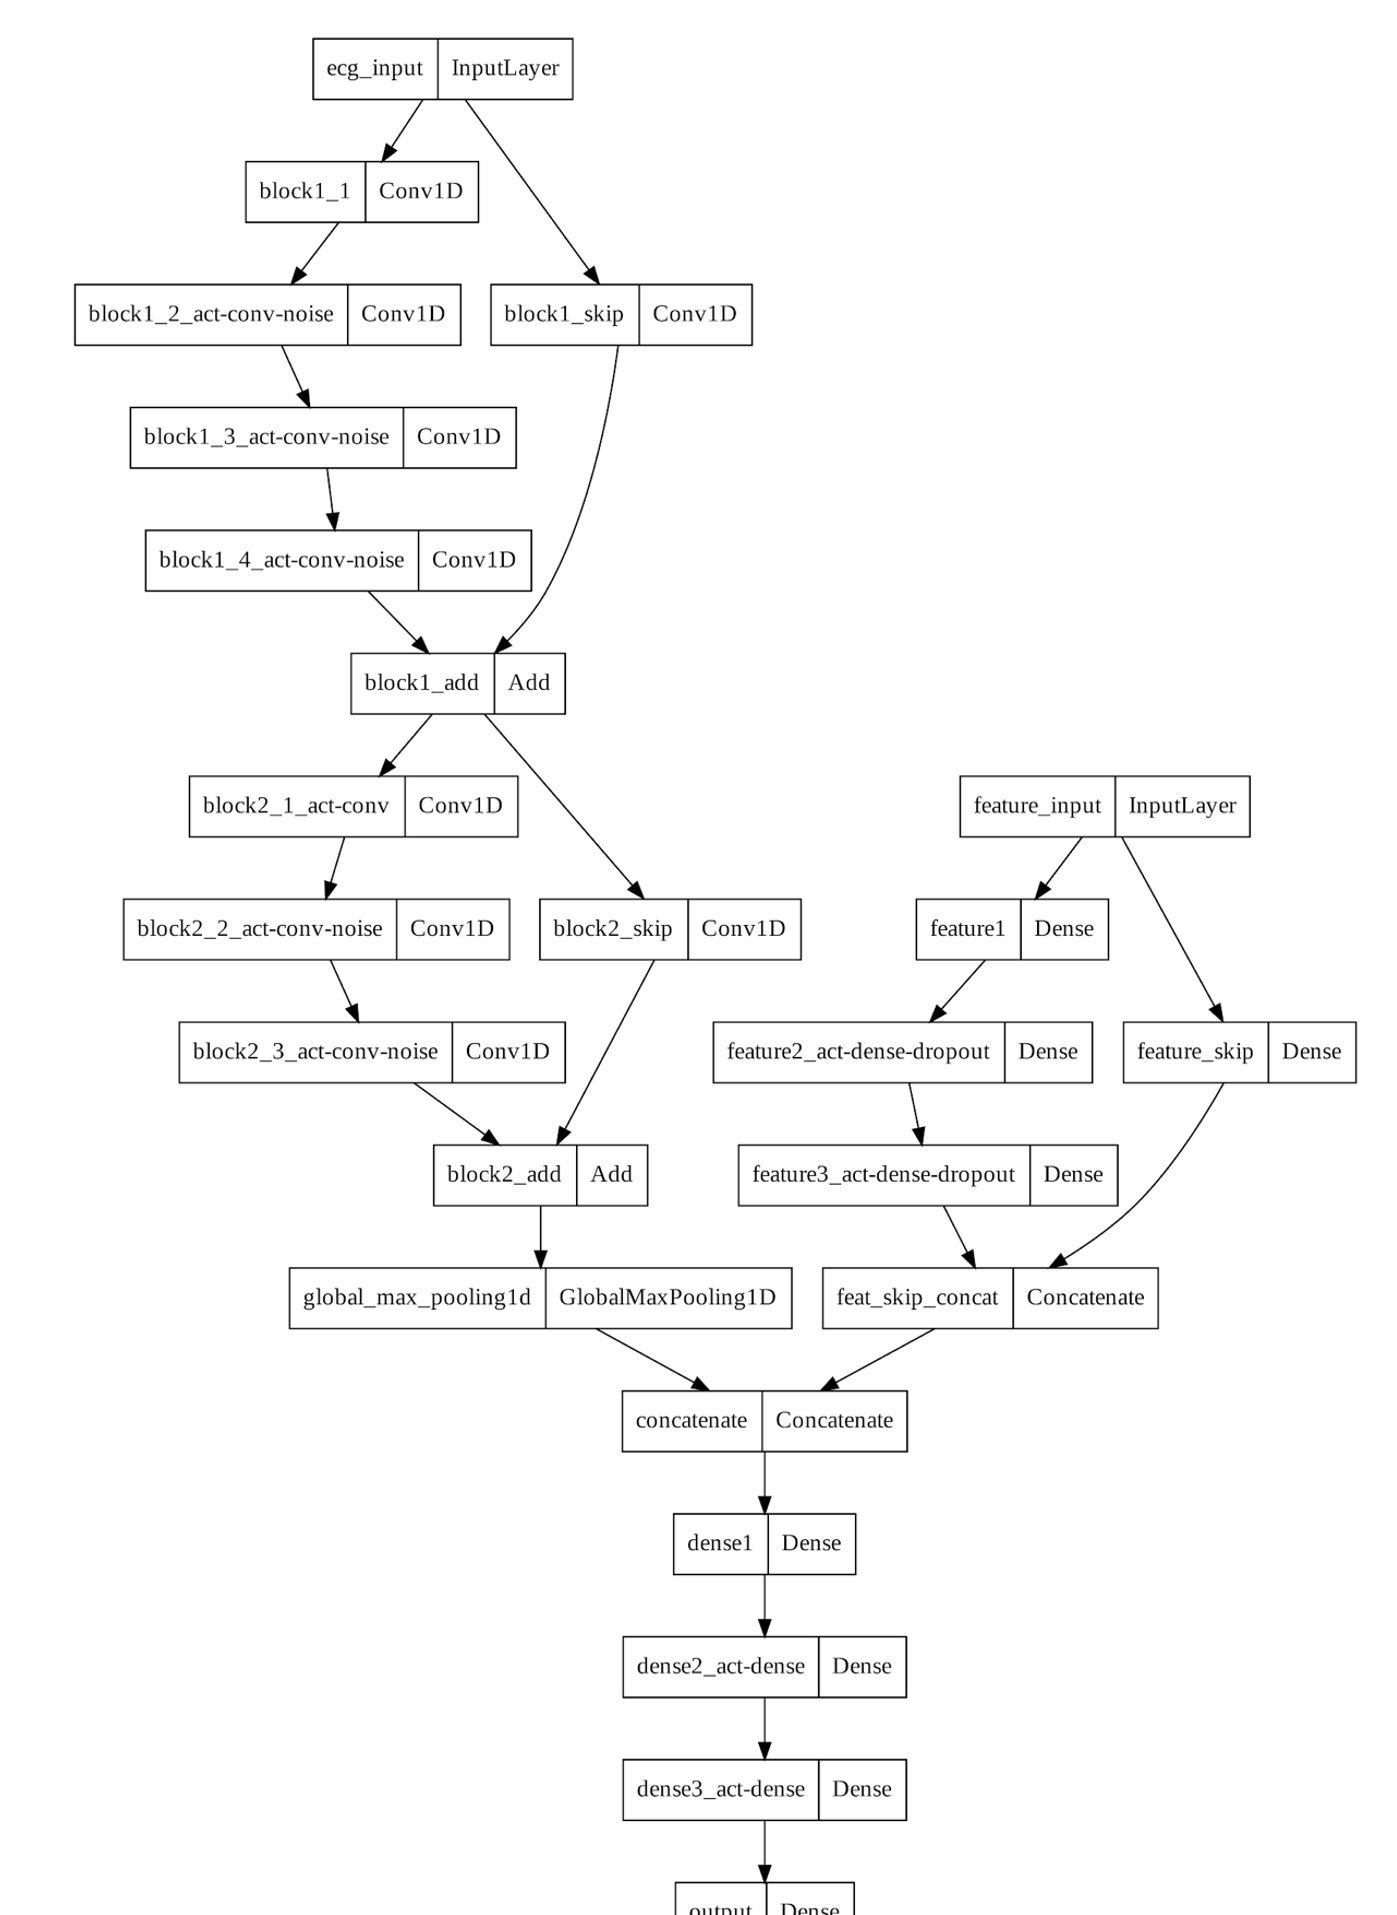


In [2]:
# Define layers of CNN - use functional API to implement residuals

#input layer (1250 time samples x 12 ECG channels)
time_samples = 1250
channels = 12

#ecg channels
ecg_inputs = keras.Input(shape=(time_samples, channels))

#convolution_params
conv_kernel_size = 56
conv_filter_size = 128
conv_dilation_rate = 3
conv_gauss_noise_stdev = 0.0013

#Block 1_1 - 1D convolution
b1_conv1D_1 = Conv1D(
    filters=conv_filter_size, 
    kernel_size=conv_kernel_size,
    dilation_rate=conv_dilation_rate)(ecg_inputs)

#act-conv_noise generic reusuable block
def act_conv_noise(inputs, block_name='ActConvNoise'):
    #with K.name_scope
        act = LeakyReLU
        conv = Conv1D
        noise = GaussianNoise
        output =0
        return output

I0000 00:00:1731508619.946140     987 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
